In [1]:
# !pip install medmnist

In [2]:
# https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [3]:
%load_ext autoreload
%autoreload 1

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm import tqdm
from utils import load_dataset

%aimport vq_vae_model

%aimport utils
from utils import plot_real_vs_constructed 
# from basic_vae import VariationalAutoencoder

In [17]:
data_flag = 'pathmnist'
#data_flag = 'breastmnist'
# data_flag = 'octmnist'
# data_flag = 'chestmnist'
#data_flag = 'bloodmnist'
#data_flag = 'organamnist'
#data_flag = 'tissuemnist'
download = True
train_dataset, test_dataset, train_loader, train_loader_at_eval, test_loader =  load_dataset(data_flag, BATCH_SIZE = 64, download = True)



Using downloaded and verified file: C:\Users\kella\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\kella\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\kella\.medmnist\pathmnist.npz


C:\Users\kella\anaconda3\envs\dgm\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


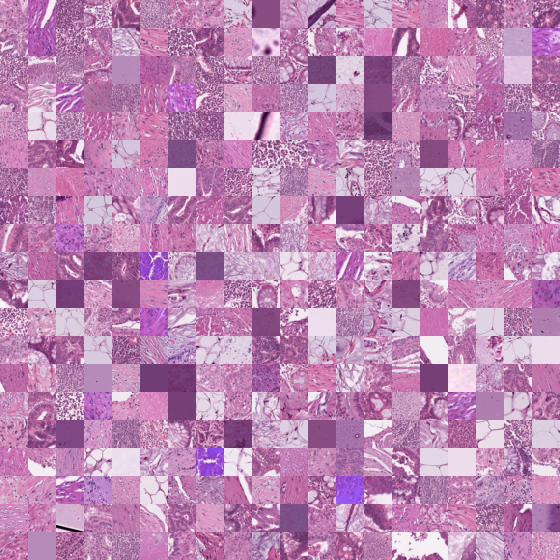

In [7]:
train_dataset.montage()

In [18]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

here you change the parameter

In [19]:
channel = 3
epochs=100
path = "{}_epochs_{}.tar".format(data_flag,epochs)

In [20]:
from vq_vae_model import VariationalAutoencoder


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost,decay,input_channel=channel ,output_channel=channel ).to(device) # GPU


#vae.train(train_loader, lr=0.0001, epochs=10, device=device)
# plot_latent(vae, train_loader)

In [21]:
#vae.save_to_file(path)
vae.load_from_file(path)

Model loaded from pathmnist_epochs_100.tar


In [23]:
def plot_real_vs_constructed(vae, test_dataset, device):
    imgs = np.zeros((4*29, 8*29, 3))
    diff = 0.
    for i in range(8):
        test_img = test_dataset[i][0][None,:,:,:].to(device)
        z = vae._encoder(test_img)
        z = vae._pre_vq_conv(z)
        loss, quantized, perplexity, _ = vae._vq_vae(z)
        img = vae._decoder(quantized)


        imgs[:28, i*28+(i*1):(i+1)*28+(i*1), :] = test_img[0].moveaxis(0, 2).cpu().detach().numpy()
        imgs[28+1:28*2+1, i*28+(i*1):(i+1)*28+(i*1), :] = img[0].moveaxis(0, 2).cpu().detach().numpy()

        diff += ((test_img - img)**2).mean()

    for i in range(8):
        test_img = test_dataset[i+8][0][None,:,:,:].to(device)
        z = vae._encoder(test_img)
        z = vae._pre_vq_conv(z)
        loss, quantized, perplexity, _ = vae._vq_vae(z)
        img = vae._decoder(quantized)

        imgs[2*29+1:3*28+3, i*28+(i*1):(i+1)*28+(i*1), :] = test_img[0].moveaxis(0, 2).cpu().detach().numpy()
        imgs[3*28+4:, i*28+(i*1):(i+1)*28+(i*1), :] = img[0].moveaxis(0, 2).cpu().detach().numpy()

        diff += ((test_img - img)**2).mean()

    print((diff/8).item())        
    plt.figure(figsize=(20,20))
    plt.imshow(imgs, cmap="gray")
    plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.004908236209303141


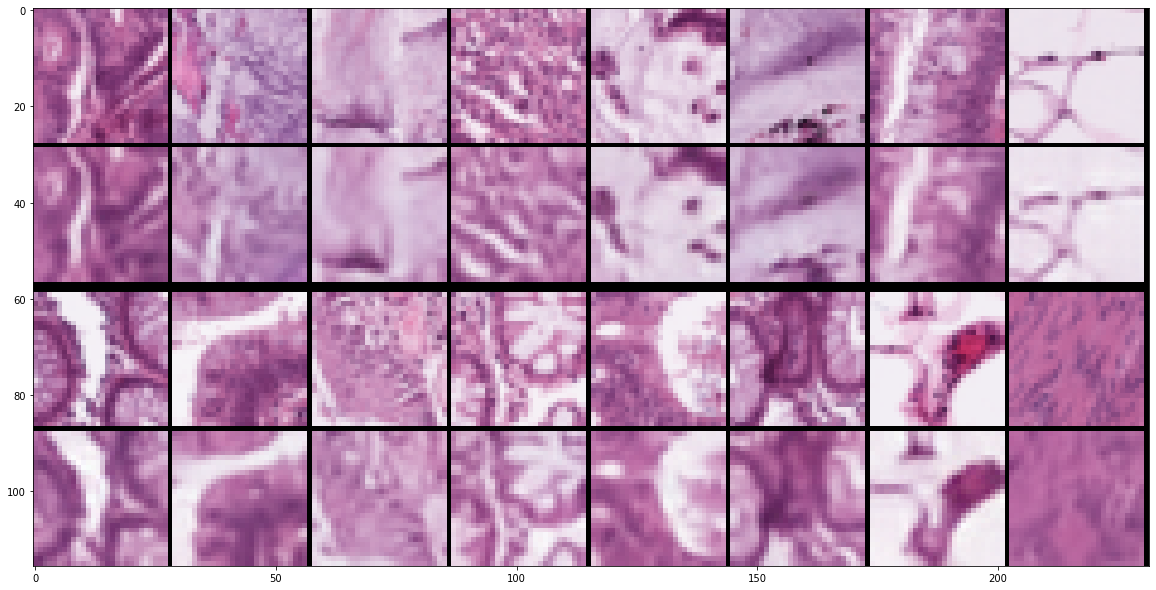

In [24]:
plot_real_vs_constructed(vae, test_dataset, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


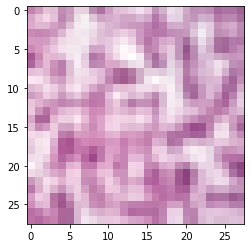

In [29]:
z = torch.torch.distributions.Uniform(torch.Tensor([0]), torch.Tensor([13])).\
                                        sample([1, num_hiddens,7,7]).view(1,num_hiddens,7,7).to(device)
z = vae._pre_vq_conv(z)
loss, quantized, perplexity, _ = vae._vq_vae(z)
img = vae._decoder.forward(quantized)
plt.imshow(img[0].moveaxis(0, 2).cpu().detach().numpy())